
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.10?urlpath=lab/tree/analysis_3d.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[analysis_3d.ipynb](../_static/notebooks/analysis_3d.ipynb) |
[analysis_3d.py](../_static/notebooks/analysis_3d.py)
</div>


# 3D analysis

This tutorial shows how to run a 3D map-based analysis using three example observations of the Galactic center region with CTA.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.extern.pathlib import Path
from gammapy.data import DataStore
from gammapy.irf import EnergyDispersion, make_mean_psf, make_mean_edisp
from gammapy.maps import WcsGeom, MapAxis, Map, WcsNDMap
from gammapy.cube import MapMaker, MapEvaluator, PSFKernel, MapFit
from gammapy.cube.models import SkyModel, SkyDiffuseCube, BackgroundModel
from gammapy.spectrum.models import PowerLaw, ExponentialCutoffPowerLaw
from gammapy.image.models import SkyGaussian, SkyPointSource
from regions import CircleSkyRegion

In [3]:
!gammapy info --no-system


Gammapy package:

	path                   : /Users/jer/git/gammapy/gammapy/gammapy 
	version                : 0.10 
	githash                : c6bfb5371a5a1682cea9aaf56ebedb3c42010a43 


Other packages:

	numpy                  : 1.16.0     
	scipy                  : 1.2.0      
	matplotlib             : 3.0.2      
	cython                 : 0.29.3     
	astropy                : 3.1.1      
	astropy_healpix        : 0.4        
	reproject              : 0.4        
	sherpa                 : 4.10.2     
	pytest                 : 4.1.1      
	sphinx                 : 1.8.3      
	healpy                 : 1.12.8     
	regions                : 0.3        
	iminuit                : 1.3.3      
	naima                  : 0.8.3      
	uncertainties          : 3.0.3      


Gammapy environment variables:

	GAMMA_CAT              : /Users/jer/git/gammapy/gamma-cat 
	GAMMAPY_DATA           : /Users/jer/DATA/GAMMAPY 
	GAMMAPY_EXTRA          : not set    
	GAMMAPY_FERMI_LAT_DATA : /Users/jer/git/ga

## Prepare modeling input data

### Prepare input maps

We first use the `DataStore` object to access the CTA observations and retrieve a list of observations by passing the observations IDs to the `.get_observations()` method:

In [4]:
# Define which data to use and print some information
data_store = DataStore.from_dir("$GAMMAPY_DATA/cta-1dc/index/gps/")
data_store.info()
print(
    "Total observation time (hours): ",
    data_store.obs_table["ONTIME"].sum() / 3600,
)
print("Observation table: ", data_store.obs_table.colnames)
print("HDU table: ", data_store.hdu_table.colnames)

Data store:
HDU index table:
BASE_DIR: /Users/jer/DATA/GAMMAPY/cta-1dc/index/gps
Rows: 24
OBS_ID: 110380 -- 111630
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_3gauss']

Observation table:
Observatory name: 'N/A'
Number of observations: 4
Total observation time (hours):  2.0
Observation table:  ['OBS_ID', 'RA_PNT', 'DEC_PNT', 'GLON_PNT', 'GLAT_PNT', 'ZEN_PNT', 'ALT_PNT', 'AZ_PNT', 'ONTIME', 'LIVETIME', 'DEADC', 'TSTART', 'TSTOP', 'DATE-OBS', 'TIME-OBS', 'DATE-END', 'TIME-END', 'N_TELS', 'OBJECT', 'CALDB', 'IRF', 'EVENTS_FILENAME', 'EVENT_COUNT']
HDU table:  ['OBS_ID', 'HDU_TYPE', 'HDU_CLASS', 'FILE_DIR', 'FILE_NAME', 'HDU_NAME']


In [5]:
# Select some observations from these dataset by hand
obs_ids = [110380, 111140, 111159]
observations = data_store.get_observations(obs_ids)

Now we define a reference geometry for our analysis, We choose a WCS based gemoetry with a binsize of 0.02 deg and also define an energy axis: 

In [6]:
energy_axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

The `MapMaker` object is initialized with this reference geometry and a field of view cut of 4 deg:

In [7]:
%%time
maker = MapMaker(geom, offset_max=4.0 * u.deg)
maps = maker.run(observations)

CPU times: user 10.5 s, sys: 1.98 s, total: 12.5 s
Wall time: 12.6 s


The maps are prepared by calling the `.run()` method and passing the `observations`. The `.run()` method returns a Python `dict` containing a `counts`, `background` and `exposure` map:

In [8]:
print(maps)

{'counts': WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 400, 9)
	ndim  : 3
	unit  : '' 
	dtype : float32 
, 'exposure': WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 400, 9)
	ndim  : 3
	unit  : 'm2 s' 
	dtype : float32 
, 'background': WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat, energy
	shape : (500, 400, 9)
	ndim  : 3
	unit  : '' 
	dtype : float32 
}


This is what the summed counts image looks like:

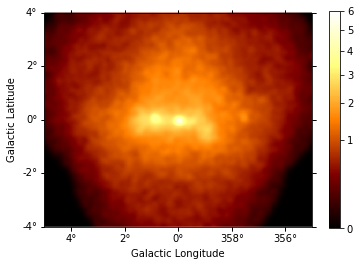

In [9]:
counts = maps["counts"].sum_over_axes()
counts.smooth(width=0.1 * u.deg).plot(stretch="sqrt", add_cbar=True, vmax=6);

This is the background image:

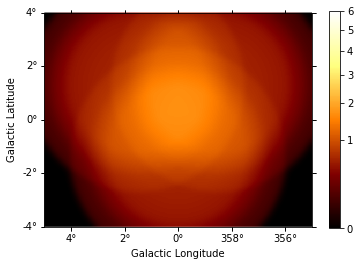

In [10]:
background = maps["background"].sum_over_axes()
background.smooth(width=0.1 * u.deg).plot(
    stretch="sqrt", add_cbar=True, vmax=6
);

And this one the exposure image:

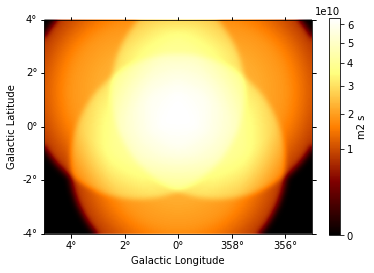

In [11]:
exposure = maps["exposure"].sum_over_axes()
exposure.smooth(width=0.1 * u.deg).plot(stretch="sqrt", add_cbar=True);

We can also compute an excess image just with  a few lines of code:

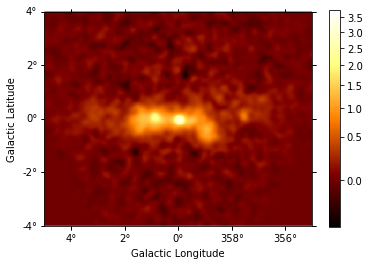

In [12]:
excess = counts - background
excess.smooth(5).plot(stretch="sqrt", add_cbar=True);

For a more realistic excess plot we can also take into account the diffuse galactic emission. For this tutorial we will load a Fermi diffuse model map that represents a small cutout for the Galactic center region:

In [13]:
diffuse_gal = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz")

In [14]:
print("Diffuse image: ", diffuse_gal.geom)
print("counts: ", maps["counts"].geom)

Diffuse image:  WcsGeom

	axes       : lon, lat, energy
	shape      : (120, 64, 30)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, -0.1 deg
	width      : 15.0 x 8.0 deg

counts:  WcsGeom

	axes       : lon, lat, energy
	shape      : (500, 400, 9)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 8.0 deg



We see that the geometry of the images is completely different, so we need to apply our geometric configuration to the diffuse emission file:

In [15]:
coord = maps["counts"].geom.get_coord()

data = diffuse_gal.interp_by_coord(
    {
        "skycoord": coord.skycoord,
        "energy": coord["energy"]
        * maps["counts"].geom.get_axis_by_name("energy").unit,
    },
    interp=3,
)
diffuse_galactic = WcsNDMap(maps["counts"].geom, data)
print("Before: \n", diffuse_gal.geom)
print("Now (same as maps): \n", diffuse_galactic.geom)

Before: 
 WcsGeom

	axes       : lon, lat, energy
	shape      : (120, 64, 30)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, -0.1 deg
	width      : 15.0 x 8.0 deg

Now (same as maps): 
 WcsGeom

	axes       : lon, lat, energy
	shape      : (500, 400, 9)
	ndim       : 3
	coordsys   : GAL
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 10.0 x 8.0 deg



WcsNDMap

	geom  : WcsGeom 
 	axes  : lon, lat
	shape : (500, 400)
	ndim  : 2
	unit  : '' 
	dtype : float32 



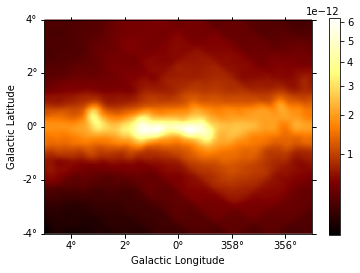

In [16]:
# diffuse_galactic.slice_by_idx({"energy": 0}).plot(add_cbar=True); # this can be used to check image at different energy bins
diffuse = diffuse_galactic.sum_over_axes()
diffuse.smooth(5).plot(stretch="sqrt", add_cbar=True)
print(diffuse)

We now multiply the exposure for this diffuse emission to subtract the result from the counts along with the background.

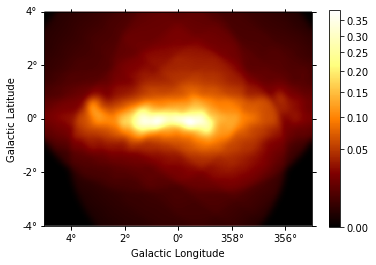

In [17]:
combination = diffuse * exposure
combination.unit = ""
combination.smooth(5).plot(stretch="sqrt", add_cbar=True);

We can plot then the excess image subtracting now the effect of the diffuse galactic emission.

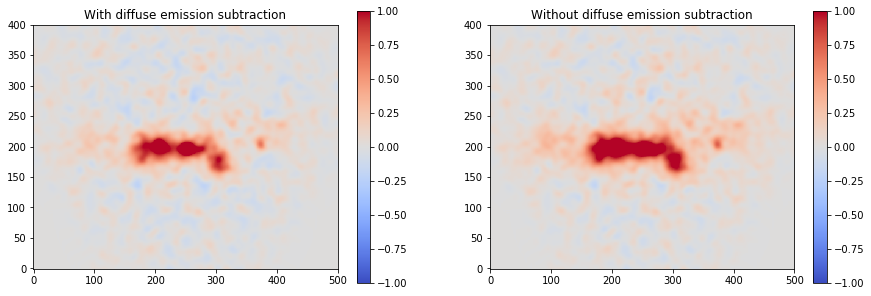

In [18]:
excess2 = counts - background - combination

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].set_title("With diffuse emission subtraction")
axs[1].set_title("Without diffuse emission subtraction")
excess2.smooth(5).plot(
    cmap="coolwarm", vmin=-1, vmax=1, add_cbar=True, ax=axs[0]
)
excess.smooth(5).plot(
    cmap="coolwarm", vmin=-1, vmax=1, add_cbar=True, ax=axs[1]
);

### Prepare IRFs

To estimate the mean PSF across all observations at a given source position `src_pos`, we use `make_mean_psf()`:

In [19]:
# mean PSF
src_pos = SkyCoord(0, 0, unit="deg", frame="galactic")
table_psf = make_mean_psf(observations, src_pos)

# PSF kernel used for the model convolution
psf_kernel = PSFKernel.from_table_psf(table_psf, geom, max_radius="0.3 deg")

To estimate the mean energy dispersion across all observations at a given source position `src_pos`, we use `make_mean_edisp()`:

In [20]:
# define energy grid
energy = energy_axis.edges * energy_axis.unit

# mean edisp
edisp = make_mean_edisp(
    observations, position=src_pos, e_true=energy, e_reco=energy
)

### Save maps and IRFs to disk

It is common to run the preparation step independent of the likelihood fit, because often the preparation of maps, PSF and energy dispersion is slow if you have a lot of data. We first create a folder:

In [21]:
path = Path("analysis_3d")
path.mkdir(exist_ok=True)

And then write the maps and IRFs to disk by calling the dedicated `.write()` methods:

In [22]:
# write maps
maps["counts"].write(str(path / "counts.fits"), overwrite=True)
maps["background"].write(str(path / "background.fits"), overwrite=True)
maps["exposure"].write(str(path / "exposure.fits"), overwrite=True)

# write IRFs
psf_kernel.write(str(path / "psf.fits"), overwrite=True)
edisp.write(str(path / "edisp.fits"), overwrite=True)

## Likelihood fit

### Reading maps and IRFs
As first step we read in the maps and IRFs that we have saved to disk again:

In [23]:
# read maps
maps = {
    "counts": Map.read(str(path / "counts.fits")),
    "background": Map.read(str(path / "background.fits")),
    "exposure": Map.read(str(path / "exposure.fits")),
}

# read IRFs
psf_kernel = PSFKernel.read(str(path / "psf.fits"))
edisp = EnergyDispersion.read(str(path / "edisp.fits"))

Let's cut out only part of the maps, so that we the fitting step does not take so long (we go from left to right one):

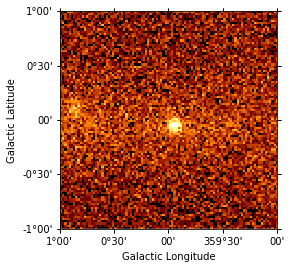

In [24]:
cmaps = {
    name: m.cutout(SkyCoord(0, 0, unit="deg", frame="galactic"), 2 * u.deg)
    for name, m in maps.items()
}
cmaps["counts"].sum_over_axes().plot(stretch="sqrt");

Insted of the complete one, which was:

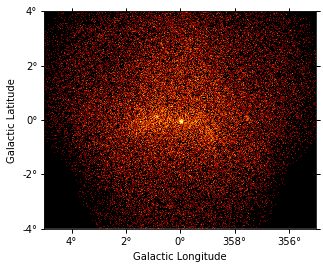

In [25]:
counts.plot(stretch="sqrt");

### Fit mask

To select a certain spatial region and/or energy range for the fit we can create a fit mask:

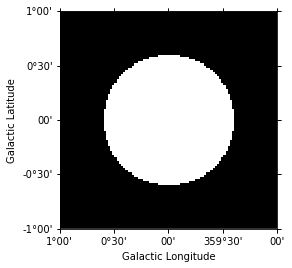

In [26]:
mask = Map.from_geom(cmaps["counts"].geom)

region = CircleSkyRegion(center=src_pos, radius=0.6 * u.deg)
mask.data = mask.geom.region_mask([region])

mask.get_image_by_idx((0,)).plot();

In addition we also exclude the range below 0.3 TeV for the fit:

In [27]:
coords = mask.geom.get_coord()
mask.data &= coords["energy"] > 0.3

### Model fit

No we are ready for the actual likelihood fit. We first define the model as a combination of a point source with a powerlaw:

In [28]:
spatial_model = SkyPointSource(lon_0="0.01 deg", lat_0="0.01 deg")
spectral_model = PowerLaw(
    index=2.2, amplitude="3e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

Now we set up the `MapFit` object by passing the prepared maps, IRFs as well as the model:

In [29]:
fit = MapFit(
    model=model,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background=cmaps["background"],
    mask=mask,
    psf=psf_kernel,
    edisp=edisp,
)

No we run the model fit:

In [30]:
%%time
result = fit.run(optimize_opts={"print_level": 1})

FCN = 14833.690007655083 
 TOTAL NCALL = 154 
 NCALLS = 154 
 
 
 EDM = 7.138458846692109e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+ 
 Name 
 Value 
 Hesse Error 
 Minos Error- 
 Minos Error+ 
 Limit- 
 Limit+ 
 Fixed? 
 
 
 0 
 par_000_lon_0 
 -4.76335 
 0.209955 
 
 
 
 
 No 
 
 
 1 
 par_001_lat_0 
 -4.83682 
 0.207396 
 
 
 
 
 No 
 
 
 2 
 par_002_index 
 2.4055 
 0.0589511 
 
 
 
 
 No 
 
 
 3 
 par_003_amplitude 
 2.82743 
 0.151382 
 
 
 
 
 No 
 
 
 4 
 par_004_reference 
 1 
 1 
 
 
 
 
 Yes 
 
 
 
 
\begin{tabular}{|c|r|r|r|r|r|r|r|c|}
\hline
 & Name & Value & Hesse Error & Minos Error- & Minos Error+ & Limit- & Limit+ & Fixed?\\
\hline
0 & par 000 $lon_{0}$ & -4.76335 & 0.209955 & & & & & No\\
\hline
1 & par 001 $lat_{0}$ & -4.83682 & 0.207396 & & & & & No\\
\hline
2 & par $002_{index}$ & 2.4055 & 0.0589511 & & & & & No\\
\hline
3 & par $003_{amplitude}$ & 2.82743 & 0.151382 & & & & & No\\
\hline
4 & par $004_{reference}$ & 1 & 1 & & & & & Yes\\
\hline
\end{tabular}

CPU times: user 3.14 s, sys: 53.1 ms, total: 3.2 s
Wall time: 3.2 s


In [31]:
print(model)

SkyModel

Parameters: 

	   name     value    error      unit      min max frozen
	--------- ---------- ----- -------------- --- --- ------
	    lon_0 -4.763e-02   nan            deg nan nan  False
	    lat_0 -4.837e-02   nan            deg nan nan  False
	    index  2.405e+00   nan                nan nan  False
	amplitude  2.827e-12   nan cm-2 s-1 TeV-1 nan nan  False
	reference  1.000e+00   nan            TeV nan nan   True


To get the errors on the model, we can check the covariance table:


In [32]:
fit.evaluator.parameters.covariance_to_table()

<Table length=5>
   name     lon_0      lat_0     index    amplitude  reference
   str9    float64    float64   float64    float64    float64 
--------- ---------- --------- ---------- ---------- ---------
    lon_0  4.408e-06 1.156e-07 -2.578e-06  1.914e-17 0.000e+00
    lat_0  1.156e-07 4.301e-06  8.924e-07  1.108e-17 0.000e+00
    index -2.578e-06 8.924e-07  3.475e-03 -3.257e-16 0.000e+00
amplitude  1.914e-17 1.108e-17 -3.257e-16  2.292e-26 0.000e+00
reference  0.000e+00 0.000e+00  0.000e+00  0.000e+00 0.000e+00

### Check model fit

We check the model fit by computing a residual image. For this we first get the number of predicted counts from the fit evaluator:

In [33]:
npred = fit.evaluator.compute_npred()

And compute a residual image:

In [34]:
residual = cmaps["counts"] - npred

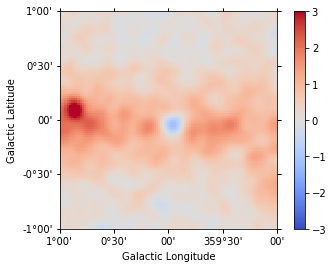

In [35]:
residual.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin=-3, vmax=3, add_cbar=True
);

We can also plot the best fit spectrum. For that need to extract the covariance of the spectral parameters.

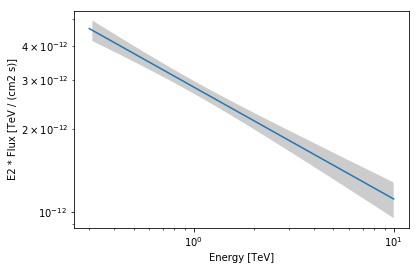

In [36]:
spec = model.spectral_model

# set covariance on the spectral model
covariance = fit.evaluator.parameters.covariance
spec.parameters.covariance = covariance[2:5, 2:5]

energy_range = [0.3, 10] * u.TeV
spec.plot(energy_range=energy_range, energy_power=2)
ax = spec.plot_error(energy_range=energy_range, energy_power=2)

Apparently our model should be improved by adding a component for diffuse Galactic emission and at least one second point
source. But before we do that in the next section, we will fit the background as a model.

### Fitting a background model

Often, it is useful to fit the normalisation (and also the index) of the background. To do so, we have to define the background as a model and pass it to `MapFit`

In [37]:
background_model = BackgroundModel(cmaps["background"], norm=1.1, tilt=0.0)

In [38]:
fit_bkg = MapFit(
    model=model,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background_model=background_model,
    mask=mask,
    psf=psf_kernel,
    edisp=edisp,
)

In [39]:
%%time
result_bkg = fit_bkg.run()

CPU times: user 3.17 s, sys: 57.4 ms, total: 3.23 s
Wall time: 3.25 s


In [40]:
print(background_model)

BackgroundModel

Parameters: 

	   name     value   error unit min max frozen
	--------- --------- ----- ---- --- --- ------
	     norm 2.147e+00   nan      nan nan  False
	     tilt 0.000e+00   nan      nan nan   True
	reference 1.000e+00   nan  TeV nan nan   True


We see we have a high normalisation of `2.15` in this case. In the next section, we add the galactic diffuse model to improve our results.

### Add Galactic diffuse emission to model

We use both models at the same time, our diffuse model (the same from the Fermi file used before) and our model for the central source. This time, in order to make it more realistic, we will consider an exponential cut off power law spectral model for the source  (note that we are not constraining the fit with any mask this time).

In [41]:
diffuse_model = SkyDiffuseCube.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/gll_iem_v06_gc.fits.gz"
)

In [42]:
spatial_model = SkyPointSource(lon_0="0.01 deg", lat_0="0.01 deg")
spectral_model = ExponentialCutoffPowerLaw(
    index=2 * u.Unit(""),
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    lambda_=1 / u.TeV,
)
model_ecpl = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)

model_combined = diffuse_model + model_ecpl

In [43]:
fit_combined = MapFit(
    model=model_combined,
    counts=cmaps["counts"],
    exposure=cmaps["exposure"],
    background=cmaps["background"],
    psf=psf_kernel,
)

In [44]:
%%time
result_combined = fit_combined.run()

CPU times: user 17.4 s, sys: 2.21 s, total: 19.6 s
Wall time: 20 s


In [45]:
print(model_ecpl)

SkyModel

Parameters: 

	   name     value    error      unit      min max frozen
	--------- ---------- ----- -------------- --- --- ------
	    lon_0 -4.797e-02   nan            deg nan nan  False
	    lat_0 -4.858e-02   nan            deg nan nan  False
	    index  2.129e+00   nan                nan nan  False
	amplitude  2.850e-12   nan cm-2 s-1 TeV-1 nan nan  False
	reference  1.000e+00   nan            TeV nan nan   True
	  lambda_  7.488e-02   nan          TeV-1 nan nan  False


As we can see we have now two components in our model, and we can access them separately.

In [46]:
# Checking normalization value (the closer to 1 the better)
print("Model 1: {}\n".format(model_combined.model1))
print("Model 2: {}".format(model_combined.model2))

Model 1: SkyDiffuseCube

Parameters: 

	name   value   error unit min max frozen
	---- --------- ----- ---- --- --- ------
	norm 1.435e+00   nan      nan nan  False

Model 2: SkyModel

Parameters: 

	   name     value    error      unit      min max frozen
	--------- ---------- ----- -------------- --- --- ------
	    lon_0 -4.797e-02   nan            deg nan nan  False
	    lat_0 -4.858e-02   nan            deg nan nan  False
	    index  2.129e+00   nan                nan nan  False
	amplitude  2.850e-12   nan cm-2 s-1 TeV-1 nan nan  False
	reference  1.000e+00   nan            TeV nan nan   True
	  lambda_  7.488e-02   nan          TeV-1 nan nan  False


We can now plot the residual image considering this improved model.

In [47]:
residual2 = cmaps["counts"] - fit_combined.evaluator.compute_npred()

Just as a comparison, we can plot our previous residual map (left) and the new one (right) with the same scale:

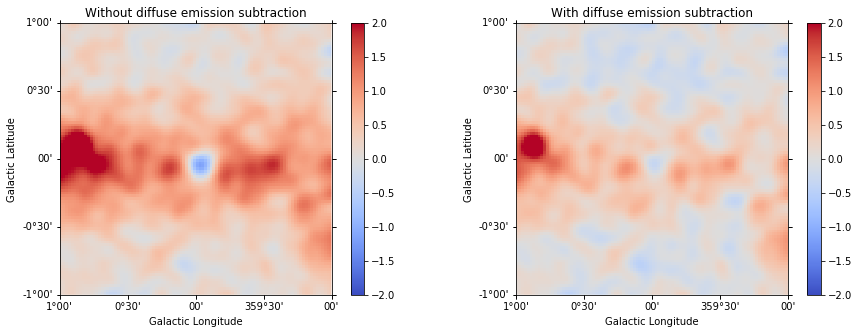

In [48]:
plt.figure(figsize=(15, 5))
ax_1 = plt.subplot(121, projection=residual.geom.wcs)
ax_2 = plt.subplot(122, projection=residual.geom.wcs)

ax_1.set_title("Without diffuse emission subtraction")
ax_2.set_title("With diffuse emission subtraction")

residual.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin=-2, vmax=2, add_cbar=True, ax=ax_1
)
residual2.sum_over_axes().smooth(width=0.05 * u.deg).plot(
    cmap="coolwarm", vmin=-2, vmax=2, add_cbar=True, ax=ax_2
);

Finally we can check again our model (including now the diffuse emission):

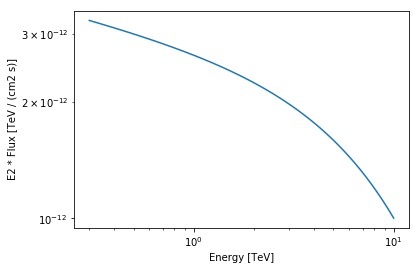

In [49]:
spec_ecpl = model_ecpl.spectral_model
ax = spec_ecpl.plot(energy_range=energy_range, energy_power=2)

Results seems to be better (but not perfect yet). Next step to improve our model even more would be getting rid of the other bright source (G0.9+0.1).

Note that this notebook aims to show you the procedure of a 3D analysis using just a few observations and a cutted Fermi model. Results get much better for a more complete analysis considering the GPS dataset from the CTA First Data Challenge (DC-1) and also the CTA model for the Galactic diffuse emission, as shown in the next image:

![](images/DC1_3d.png)

The complete tutorial notebook of this analysis is available to be downloaded in [GAMMAPY-EXTRA](https://github.com/gammapy/gammapy-extra) repository at https://github.com/gammapy/gammapy-extra/blob/master/analyses/cta_1dc_gc_3d.ipynb).

## Exercises

* Analyse the second source in the field of view: G0.9+0.1 and add it to the combined model.